In [1]:
import os
from utils.configuration import *

In [2]:
experiment_name = "ordinal_vars_test"      ## <--- set experiment name
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"  ## <--- set log directory
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

In [3]:
setup_configuration(experiment_name,EXPERIMENT_DIR)

Configuration already exists/home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/configuration.json


In [4]:
# here you need to specify which varibles are in the graph and what type they are (continous or ordinal) for the model builder 
data_type= {'x1':'continous',
            'x2':'continous',
            'x3':'continous',
            'x4':'continous',
            't1':'ordinal_Xn_Yo',
            't2':'ordinal_Xn_Yo',
            'x5':'continous',
            'y':'continous',
} 

write_data_type_to_configuration(data_type, CONF_DICT_PATH)

Variable 'x1' is modeled as a continuous variable. for target and predictor.
Variable 'x2' is modeled as a continuous variable. for target and predictor.
Variable 'x3' is modeled as a continuous variable. for target and predictor.
Variable 'x4' is modeled as a continuous variable. for target and predictor.
Variable 't1' is modeled as an ordinal   variable. As PREDICTOR: OneHot and TARGET: OneHot.
Variable 't2' is modeled as an ordinal   variable. As PREDICTOR: OneHot and TARGET: OneHot.
Variable 'x5' is modeled as a continuous variable. for target and predictor.
Variable 'y' is modeled as a continuous variable. for target and predictor.
Configuration updated successfully.


/home/bule/TramDag/utils/configuration.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


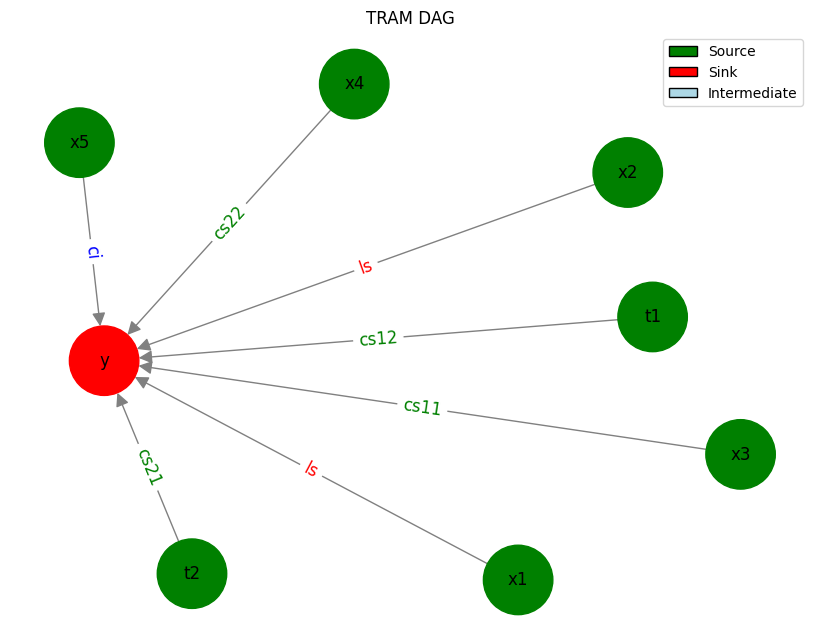

In [5]:
interactive_adj_matrix(CONF_DICT_PATH,seed=13)

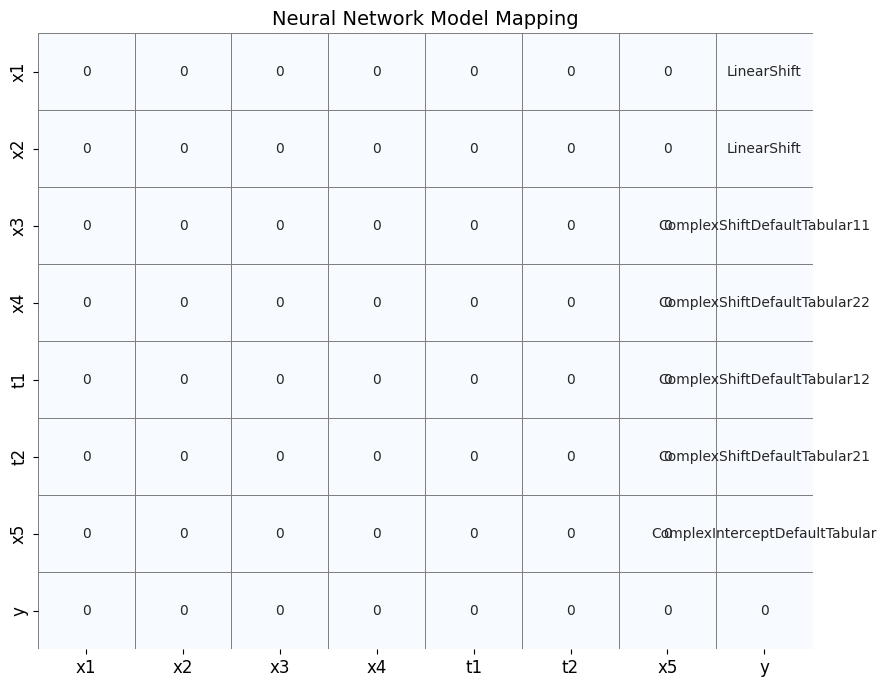

In [6]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import pandas as pd
from scipy.special import logit

df = pd.DataFrame(
    make_blobs(n_samples=1000, centers=8, n_features=8, random_state=13)[0],
    columns=['x1','x2','x3','x4','t1','t2','x5','y']
)


df['t1'] = (df['t1'] > df['t1'].median()).astype(int)
df['t2']=df['t1'].copy()
print(df.head())
df.info()


         x1        x2         x3         x4  t1  t2        x5         y
0  3.871036  0.722194   1.769079   7.942091   0   0  4.028598 -4.198753
1 -4.767804 -3.015394 -12.782749  -1.878498   1   1 -3.802016  9.414157
2  5.346699 -5.625096   7.125455  11.368677   1   1  1.743704  6.058449
3  5.087093 -7.688708   4.610315   0.677007   0   0 -2.772068 -6.691281
4 -4.538803 -2.574087  -9.519076  -3.778644   1   1 -2.202291  8.141716
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      1000 non-null   float64
 1   x2      1000 non-null   float64
 2   x3      1000 non-null   float64
 3   x4      1000 non-null   float64
 4   t1      1000 non-null   int64  
 5   t2      1000 non-null   int64  
 6   x5      1000 non-null   float64
 7   y       1000 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 62.6 KB


In [8]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [9]:
from utils.tramdag import TramDagConfig , TramDagModel

cfg = TramDagConfig.load("/home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/configuration.json")
cfg.compute_levels(train_df)
device='cpu'

In [10]:
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=True,device=device,initial_data = train_df) 
# 1m52s

[DEBUG] TramDagModel using device: cpu

[INFO] Building model for node 'x1' with settings: {'set_initial_weights': False, 'debug': True, 'verbose': True, 'device': 'cpu', 'initial_data':            x1        x2         x3         x4  t1  t2        x5         y
29   3.778917  4.714700  -9.851478  -4.456896   0   0 -2.687294  3.081479
535  3.889792 -5.370922   6.044058  10.270231   1   1  2.924395  4.847949
695  6.206760 -8.519790   3.775468  -0.589031   0   0 -5.405793 -7.208941
557  9.225430  3.118023  -2.340624   1.365715   1   1  5.754246 -0.620253
836 -5.234281 -1.144617 -10.320686  -2.702879   1   1 -2.577204  7.960361
..        ...       ...        ...        ...  ..  ..       ...       ...
106  6.316279 -5.501693   6.777211   8.925328   1   1  3.449907  5.767779
270 -6.629046 -3.360969  -9.827372  -3.679498   1   1 -3.676727  7.263038
860 -3.455477  5.100309   7.269814  -5.309903   1   1 -3.981180  1.707555
435  4.814736 -8.762771   4.717201   4.009265   0   0 -6.227229 -6.199344

In [11]:
td_model.fit(train_df, val_df,
             epochs=30,batch_size=1_000,
             verbose=True,debug=False,
             device=device,
             num_workers = 8,
             persistent_workers = True,
             prefetch_factor = 8,
             train_mode = "sequential")#,

#30 eps 1m 49s seq mode from start 1000 bs
#30 eps 2m 27s parllel multiprocessing mode from start 1000 bs
# 200 eps 9m 30s seq mode from start 1000 bs

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/min_max_scaling.json
[INFO] Training 8 nodes (sequential) on cpu

[INFO] Training node 'x1' for 30 epochs on cpu (pid=6108)
[INFO] Existing model found. Loading weights and history...

===== Epoch 8/30 =====


[INFO] Saved new best model.
[INFO] Epoch 8: Train NLL=4.4711 | Val NLL=4.4664 | Time=0.58s

[INFO] Training node 'x2' for 30 epochs on cpu (pid=6108)
[INFO] Existing model found. Loading weights and history...

===== Epoch 8/30 =====
[INFO] Saved new best model.
[INFO] Epoch 8: Train NLL=4.3050 | Val NLL=4.2702 | Time=0.47s

[INFO] Training node 'x3' for 30 epochs on cpu (pid=6108)
[INFO] Existing model found. Loading weights and history...

===== Epoch 8/30 =====
[INFO] Saved new best model.
[INFO] Epoch 8: Train NLL=4.7884 | Val NLL=4.8133 | Time=0.42s

[INFO] Training node 'x4' for 30 epochs on cpu (pid=6108)
[INFO] Existing model found. Loading weights and history...

===== Epoch 8/30 =====
[INFO] Saved new best model.
[INFO] Epoch 8: Train NLL=4.5919 | Val NLL=4.5559 | Time=0.44s

[INFO] Training node 't1' for 30 epochs on cpu (pid=6108)
[INFO] Existing model found. Loading weights and history...

===== Epoch 8/30 =====
[INFO] Saved new best model.
[INFO] Epoch 8: Train NLL=0.732

In [12]:
latents=td_model.get_latent( train_df)

[INFO] Skipping node 't1' (ordinal targets not yet supported).
[INFO] Skipping node 't2' (ordinal targets not yet supported).
[INFO] Final latent DataFrame shape: (800, 12)


In [13]:
samples, latents = td_model.sample(device='cuda',debug=True)

[DEBUG] sample(): device: cuda
[INFO] Starting full DAG sampling with 10000 samples per node.
[DEBUG] sample_full_dag: device: cuda
[INFO] Deleting all previously sampled data.
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x3/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x4/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/t1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/t2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x5/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/y/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Samp

Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 329.45it/s]

[DEBUG] sample_continous_modelled_target: root finding complete. Sampled shape: torch.Size([10000])
[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x2 from standard logistic distribution
[DEBUG] get_fully_specified_tram_model(): device: cuda
[DEBUG] default_number_thetas for continuous outcomes: 20
[DEBUG] Set df: type=<class 'pandas.core.frame.DataFrame'>, shape=(10000, 1)
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?
[DEBUG] target_col 'x2' not found in DataFrame columns
[DEBUG] Set all_nodes_dict: type=<class 'dict'>, keys=['x1', 'x2', 'x3', 'x4', 't1', 't2', 'x5', 'y']
[DEBUG] Set parents_datatype_dict: type=<class 'collections.OrderedDict'>, keys=[]
[DEBUG] Set transformation_terms_preprocessing: type=<class 'list'>, value=[]
[DEBUG] Set predictors: type=<class 'list'>, value=[]
[DEBUG] Set transf

[DEBUG] sample_continous_modelled_target: source node, defaults to SI and 1 as inputs
[DEBUG] sample_continous_modelled_target: beginning root finding
[DEBUG] sample_continous_modelled_target: thetas_expanded shape: torch.Size([10000, 20])
[DEBUG] sample_continous_modelled_target: shifts shape: torch.Size([10000])
[DEBUG] sample_continous_modelled_target: latent_sample shape: torch.Size([10000])


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 327.37it/s]

[DEBUG] sample_continous_modelled_target: root finding complete. Sampled shape: torch.Size([10000])
[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x3 from standard logistic distribution
[DEBUG] get_fully_specified_tram_model(): device: cuda
[DEBUG] default_number_thetas for continuous outcomes: 20
[DEBUG] Set df: type=<class 'pandas.core.frame.DataFrame'>, shape=(10000, 1)
[WARNING] target_col 'x3' not in DataFrame columns — is this intended to be used as a Sampler?
[DEBUG] target_col 'x3' not found in DataFrame columns
[DEBUG] Set all_nodes_dict: type=<class 'dict'>, keys=['x1', 'x2', 'x3', 'x4', 't1', 't2', 'x5', 'y']
[DEBUG] Set parents_datatype_dict: type=<class 'collections.OrderedDict'>, keys=[]
[DEBUG] Set transformation_terms_preprocessing: type=<class 'list'>, value=[]
[DEBUG] Set predictors: type=<class 'list'>, value=[]
[DEBUG] Set transf

[DEBUG] sample_continous_modelled_target: source node, defaults to SI and 1 as inputs
[DEBUG] sample_continous_modelled_target: beginning root finding
[DEBUG] sample_continous_modelled_target: thetas_expanded shape: torch.Size([10000, 20])
[DEBUG] sample_continous_modelled_target: shifts shape: torch.Size([10000])
[DEBUG] sample_continous_modelled_target: latent_sample shape: torch.Size([10000])


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:31<00:00, 321.03it/s]

[DEBUG] sample_continous_modelled_target: root finding complete. Sampled shape: torch.Size([10000])
[INFO] Completed sampling for node 'x3'

----*----------*-------------*--------Sample Node: x4 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x4 from standard logistic distribution
[DEBUG] get_fully_specified_tram_model(): device: cuda
[DEBUG] default_number_thetas for continuous outcomes: 20
[DEBUG] Set df: type=<class 'pandas.core.frame.DataFrame'>, shape=(10000, 1)
[WARNING] target_col 'x4' not in DataFrame columns — is this intended to be used as a Sampler?
[DEBUG] target_col 'x4' not found in DataFrame columns
[DEBUG] Set all_nodes_dict: type=<class 'dict'>, keys=['x1', 'x2', 'x3', 'x4', 't1', 't2', 'x5', 'y']
[DEBUG] Set parents_datatype_dict: type=<class 'collections.OrderedDict'>, keys=[]
[DEBUG] Set transformation_terms_preprocessing: type=<class 'list'>, value=[]
[DEBUG] Set predictors: type=<class 'list'>, value=[]
[DEBUG] Set transf

[DEBUG] sample_continous_modelled_target: source node, defaults to SI and 1 as inputs
[DEBUG] sample_continous_modelled_target: beginning root finding
[DEBUG] sample_continous_modelled_target: thetas_expanded shape: torch.Size([10000, 20])
[DEBUG] sample_continous_modelled_target: shifts shape: torch.Size([10000])
[DEBUG] sample_continous_modelled_target: latent_sample shape: torch.Size([10000])


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 329.16it/s]

[DEBUG] sample_continous_modelled_target: root finding complete. Sampled shape: torch.Size([10000])
[INFO] Completed sampling for node 'x4'

----*----------*-------------*--------Sample Node: t1 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node t1 from standard logistic distribution
[DEBUG] get_fully_specified_tram_model(): device: cuda
[DEBUG] default_number_thetas for continuous outcomes: 20
[DEBUG] Set df: type=<class 'pandas.core.frame.DataFrame'>, shape=(10000, 1)
[WARNING] target_col 't1' not in DataFrame columns — is this intended to be used as a Sampler?
[DEBUG] target_col 't1' not found in DataFrame columns
[DEBUG] Set all_nodes_dict: type=<class 'dict'>, keys=['x1', 'x2', 'x3', 'x4', 't1', 't2', 'x5', 'y']
[DEBUG] Set parents_datatype_dict: type=<class 'collections.OrderedDict'>, keys=[]
[DEBUG] Set transformation_terms_preprocessing: type=<class 'list'>, value=[]
[DEBUG] Set predictors: type=<class 'list'>, value=[]
[DEBUG] Set transf

[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size([32, 1])
[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size([32, 1])
[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size([32, 1])
[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size([32, 1])
[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size([32, 1])
[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size([32, 1])
[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size([32, 1])
[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: torch.Size([32, 1])
[DEBUG] Batch model_outputs keys: dict_keys(['int_out', 'shift_out'])
[DEBUG] int_out shape: tor

Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 322.61it/s]


[DEBUG] sample_continous_modelled_target: root finding complete. Sampled shape: torch.Size([10000])
[INFO] Completed sampling for node 'x5'

----*----------*-------------*--------Sample Node: y ------------*-----------------*-------------------*--
[DEBUG] check_sampled_and_latents: Found 'sampled.pt' in /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x1/sampling
[DEBUG] check_sampled_and_latents: Found 'latents.pt' in /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x1/sampling
[DEBUG] check_sampled_and_latents: Found 'sampled.pt' in /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x2/sampling
[DEBUG] check_sampled_and_latents: Found 'latents.pt' in /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x2/sampling
[DEBUG] check_sampled_and_latents: Found 'sampled.pt' in /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x3/sampling
[DEBUG] check_sampled_and_latents: Found 'latents.pt' in /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x3/sampl

Chandrupatla root finding: 100%|██████████| 10000/10000 [00:31<00:00, 321.59it/s]

[DEBUG] sample_continous_modelled_target: root finding complete. Sampled shape: torch.Size([10000])
[INFO] Completed sampling for node 'y'
[INFO] DAG sampling completed successfully for all nodes.


In [14]:
cfg.conf_dict

{'date_of_creation': '2025-10-09 16:20:31',
 'experiment_name': 'ordinal_vars_test',
 'PATHS': {'DATA_PATH': '/home/bule/TramDag/dev_experiment_logs/ordinal_vars_test',
  'LOG_DIR': None,
  'EXPERIMENT_DIR': '/home/bule/TramDag/dev_experiment_logs/ordinal_vars_test'},
 'data_type': {'x1': 'continous',
  'x2': 'continous',
  'x3': 'continous',
  'x4': 'continous',
  't1': 'ordinal_Xn_Yo',
  't2': 'ordinal_Xn_Yo',
  'x5': 'continous',
  'y': 'continous'},
 'adj_matrix': [['0', '0', '0', '0', '0', '0', '0', 'ls'],
  ['0', '0', '0', '0', '0', '0', '0', 'ls'],
  ['0', '0', '0', '0', '0', '0', '0', 'cs11'],
  ['0', '0', '0', '0', '0', '0', '0', 'cs22'],
  ['0', '0', '0', '0', '0', '0', '0', 'cs12'],
  ['0', '0', '0', '0', '0', '0', '0', 'cs21'],
  ['0', '0', '0', '0', '0', '0', '0', 'ci'],
  ['0', '0', '0', '0', '0', '0', '0', '0']],
 'model_names': [['0', '0', '0', '0', '0', '0', '0', 'LinearShift'],
  ['0', '0', '0', '0', '0', '0', '0', 'LinearShift'],
  ['0', '0', '0', '0', '0', '0', '0',

In [15]:
sampled_df

NameError: name 'sampled_df' is not defined

In [ ]:


from utils.tram_data import *
from torch.utils.data import *
from utils.tram_model_helpers import get_fully_specified_tram_model
from utils.tram_data_helpers import create_df_from_sampled

node='y'
number_of_samples=100
target_nodes_dict=cfg.conf_dict['nodes']
NODE_DIR="/home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/y"

MODEL_PATH = os.path.join(NODE_DIR, "best_model.pt")
tram_model = get_fully_specified_tram_model(node, cfg.conf_dict, debug=True, device=device,verbose=False).to(device)
tram_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

print(target_nodes_dict)

# isntead of sample loader use Generic Dataset but the df is just to sampled data from befor -> create df for each node
sampled_df=create_df_from_sampled(node, target_nodes_dict, number_of_samples, EXPERIMENT_DIR)

sample_dataset = GenericDataset(sampled_df,target_col=node,
                                    target_nodes=target_nodes_dict,
                                    return_intercept_shift=True,
                                    return_y=False,
                                    debug=True)

sample_loader = DataLoader(sample_dataset, batch_size=32, shuffle=False,num_workers=4, pin_memory=True)
                

[DEBUG] get_fully_specified_tram_model(): device: cpu
[DEBUG] default_number_thetas for continuous outcomes: 20
{'x1': {'Modelnr': 0, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'batch_size': 512, 'epochs': 100, 'learning_rate': 0.01, 'use_scheduler': False, 'transformation_term_nn_models_in_h()': {}}, 'x2': {'Modelnr': 1, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'batch_size': 512, 'epochs': 100, 'learning_rate': 0.01, 'use_scheduler': False, 'transformation_term_nn_models_in_h()': {}}, 'x3': {'Modelnr': 2, 'data_type': 'continous', 'node_type': 'source', 'parents': [], 'parents_datatype': {}, 'transformation_terms_in_h()': {}, 'batch_size': 512, 'epochs': 100, 'learning_rate': 0.01, 'use_scheduler': False, 'transformation_term_nn_models_in_h()': {}}, 'x4': {'Modelnr': 3, 'data_type': 'continous', 'node_type': 'source', 'parent

In [ ]:
samples, latents = td_model.sample(predefined_latent_samples_df=latents, device='cuda') #BUG fix  for ordinal vars sample loader ..

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 800
[INFO] Deleting all previously sampled data.
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x3/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x4/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/t1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/t2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/x5/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal_vars_test/y/sampling

----*----------*-------------*--------Sample Node: x1 -----

Chandrupatla root finding:  27%|██▋       | 2660/10000 [00:07<00:21, 336.98it/s]


KeyboardInterrupt: 

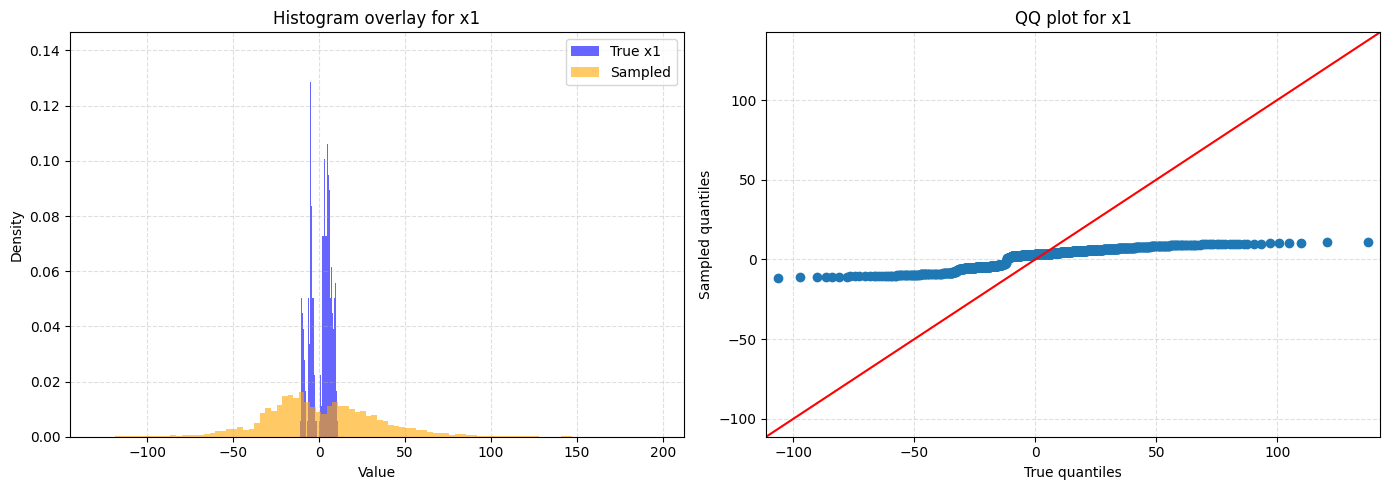

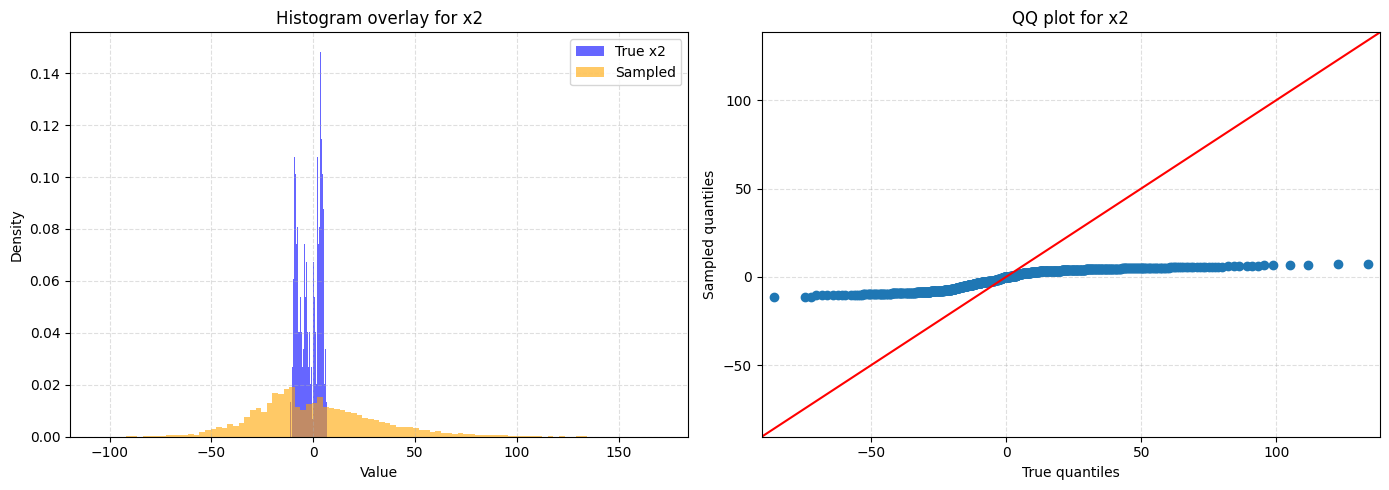

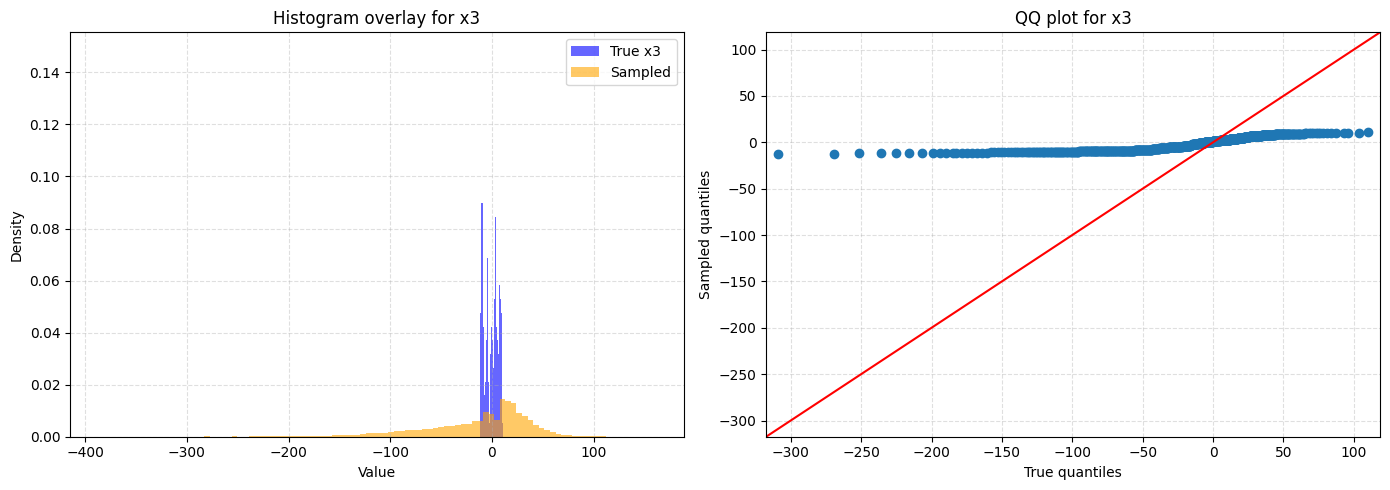

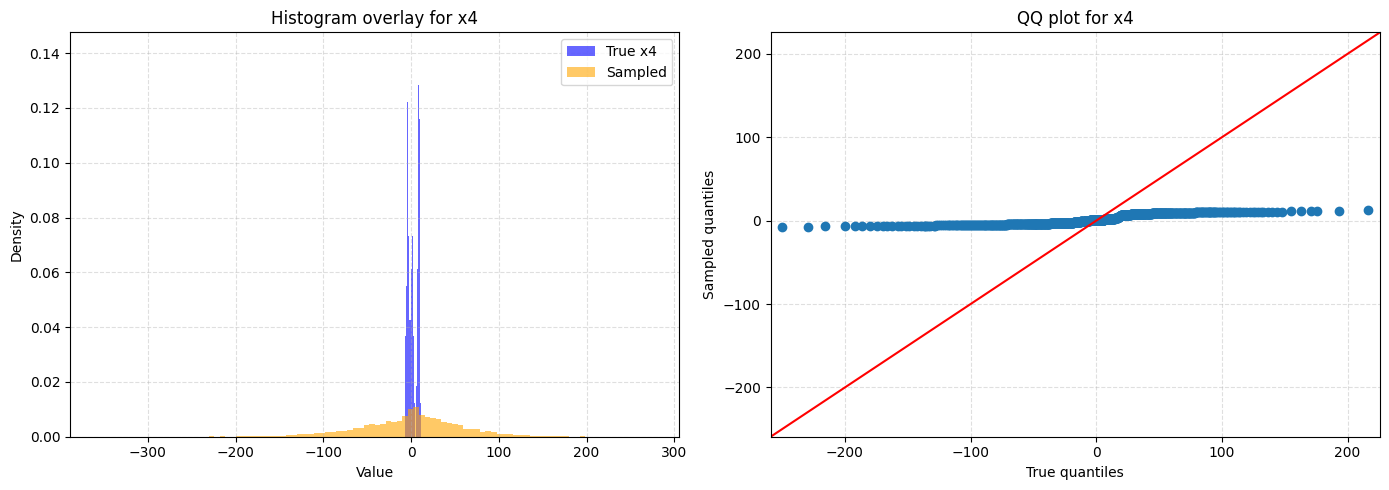

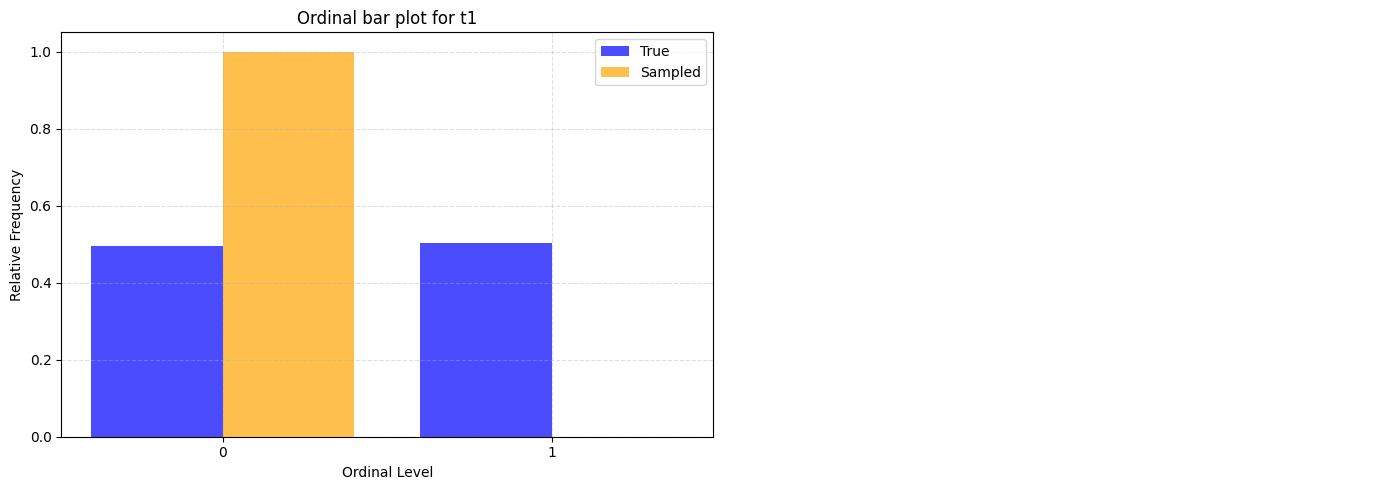

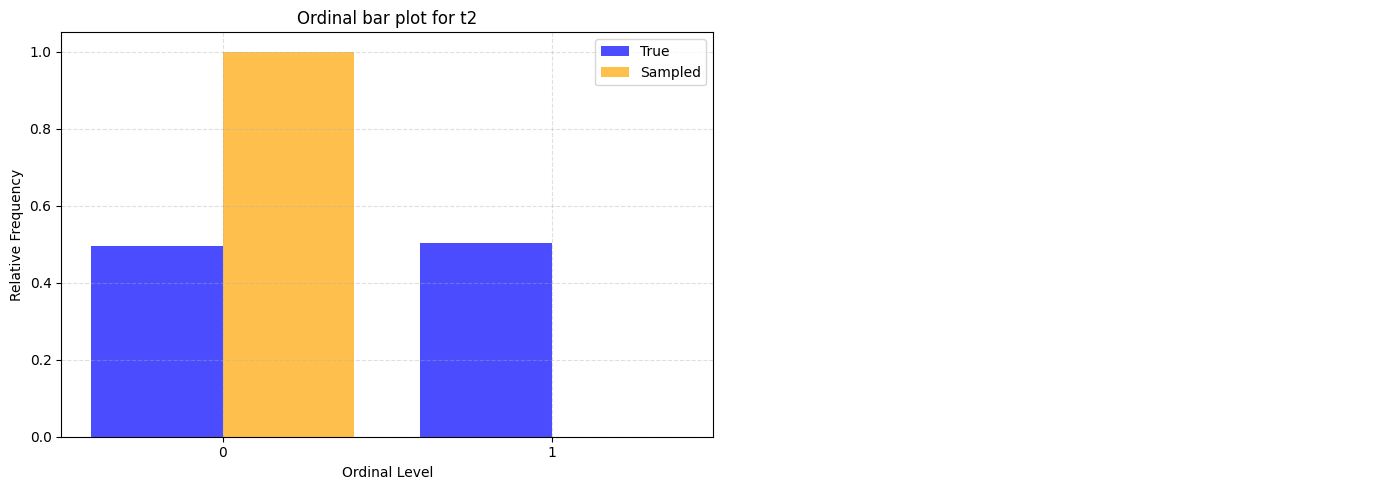

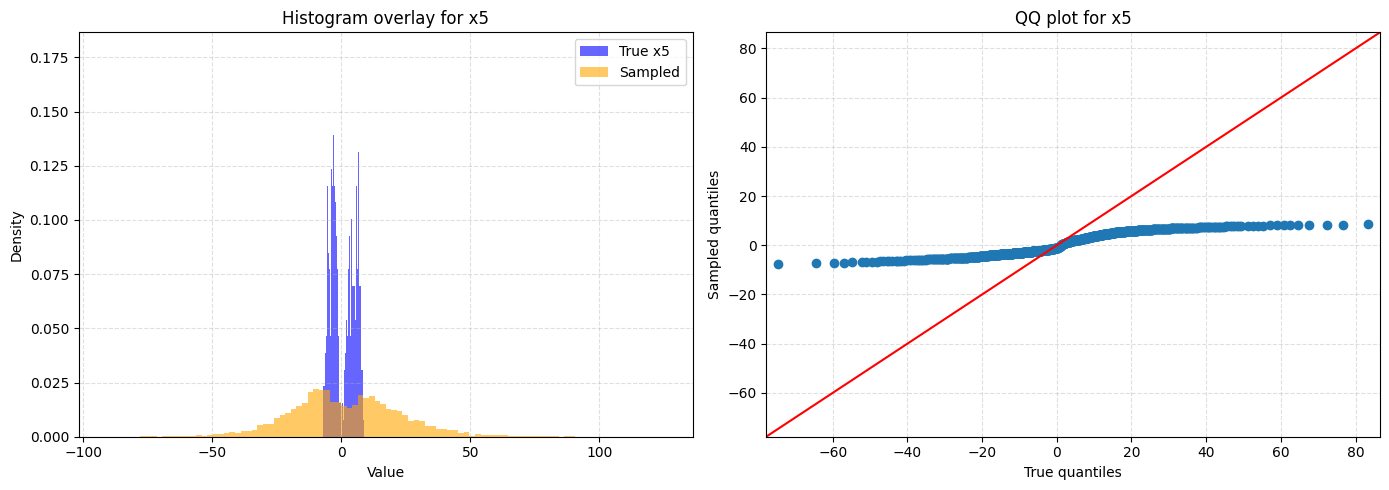

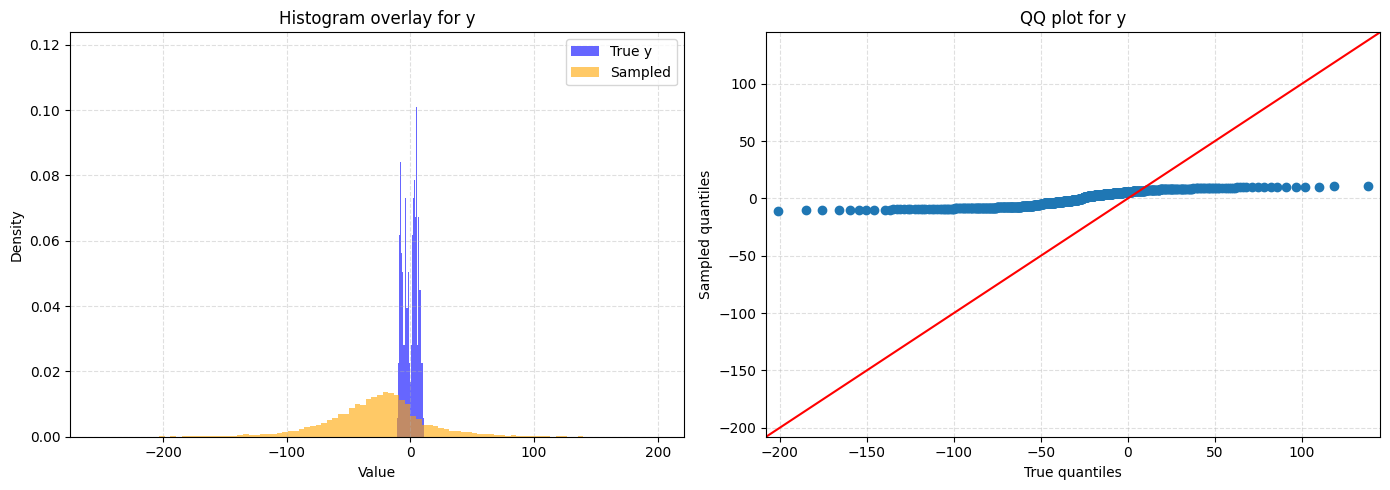

In [16]:
td_model.show_samples_vs_true(train_df)